In [1]:
using LinearAlgebra, Random, StatsBase

### Generation of random matrix completion problems

A matrix completion problem is a problem of the form
\begin{align}
\mbox{reconstruct } & M \in\mathbb{R}^{n\times n} \\
\mbox{from } & (M_{i,j})_{(i,j) \in \Omega},
\end{align}
where $n$ is an integer and $\Omega$ is a known subset of $\{1,\dots,n\}^2$.

Without further information on $M$, this problem is ill-posed: the unobserved coefficients of $M$ can be attributed any value. Here, we make two additional assumptions:
* the rank of $M$ is smaller than some known integer $r_0$;
* $M$ is positive semidefinite.
  
The problem therefore rewrites
\begin{align}
\mbox{reconstruct } & M \in\mathbb{R}^{n\times n} \\
\mbox{from } & (M_{i,j})_{(i,j) \in \Omega}, \\
\mbox{such that } & M \succeq 0 \\
\mbox{and } & \mathrm{rank}(M) \leq r_0.
\end{align}

Our first function generates a random matrix completion problem, for given values of $n,r_0$ and cardinality of $\Omega$.

In [2]:
function completion_problem(n,r,m)
    # The unknown matrix has size nxn and rank r.
    # The number of observations (= number of elements in Omega) is m.

    # Generate M
    M = randn(n,r)
    M = M * M'

    # Generate Omega
    Omega = []
    while (length(Omega) < m)
        i = rand(1:n)
        j = rand(1:n)
        # Since M is symmetric, we can limit ourselves to pairs (i,j) such that i<=j.
        if (i<=j) && ~((i,j) in Omega)
            Omega = [Omega ; (i,j)]
        end
    end

    meas = [M[i,j] for (i,j) in Omega]
    return meas, Omega, M
end

completion_problem (generic function with 1 method)

### Algorithm

We consider the standard convex relaxation of the above problem:
\begin{align}
\mbox{minimize } & \mathrm{Tr}(M) \\
\mbox{over all } & M\in\mathbb{R}^{n\times n}\\
\mbox{such that } & M\succeq 0 \\
\mbox{and } & M_{i,j} = b_{i,j}, \forall (i,j) \in \Omega.
\end{align}
Here, $b$ is the vector of measurements.

In [3]:
using JuMP, SCS

In [4]:
function convex_relax(n,Omega,b)
    model = Model(SCS.Optimizer)
    set_silent(model)
    @variable(model, M[1:n, 1:n], PSD)
    @objective(model, Min, tr(M))
    for k=1:length(Omega)
        @constraint(model, M[Omega[k][1],Omega[k][2]] == b[k])
    end
    t = time()
    JuMP.optimize!(model)
    t_opt = time()-t
    return JuMP.value.(M), t_opt
end

convex_relax (generic function with 1 method)

In [5]:
# Quick test
n = 5
r = 1
m = 10
b, Omega, M = completion_problem(n,r,m)
M_sol,_ = convex_relax(n,Omega,b)
display(M)
display(M_sol)

5×5 Matrix{Float64}:
  0.932261  -1.07202   1.10922   2.4333   -1.26629
 -1.07202    1.23273  -1.27551  -2.79809   1.45613
  1.10922   -1.27551   1.31976   2.89518  -1.50665
  2.4333    -2.79809   2.89518   6.35119  -3.30517
 -1.26629    1.45613  -1.50665  -3.30517   1.72001

5×5 Matrix{Float64}:
  0.932262  -1.07202   1.10922   2.43411  -1.26629
 -1.07202    1.23273  -1.27516  -2.79777   1.45613
  1.10922   -1.27516   1.31976   2.89478  -1.50665
  2.43411   -2.79777   2.89478   6.35119  -3.30516
 -1.26629    1.45613  -1.50665  -3.30516   1.71929

For simplicity, in this notebook, we will limit ourselves to $r_0=1$ (but you can of course experiment with other values!).

We first investigate for which values of $n,m$ the convex relaxation is able to exactly recover the unknown matrix $M$.

In [6]:
using Plots

In [7]:
function empirical_rec_proba(r,ns,algo;nb_tests=nb_tests)

    pl = plot(xlabel="m/nlog(n)",ylabel="reconstruction probability")
    for n in ns
        println("n = ",n)
        ms = [round(Int64,n*log(n)*k) for k=0.1:0.25:2]
        ms = ms[ms .<= n*(n+1)/2]

        nb_success = zeros(length(ms))
        print("  m = ")
        for k=1:length(ms)
            print(" ",ms[k])
            flush(stdout)
            for k_test = 1:nb_tests
                b, Omega, M = completion_problem(n,r,ms[k])
                M_sol = algo(n,Omega,b)
                if (norm(M-M_sol) < 1e-2*norm(M_sol))
                    nb_success[k] += 1
                end
            end
        end
        println("")
        proba_success = nb_success / nb_tests
        plot!(pl,ms/n/log(n),proba_success,label=string("n=",n))
    end
    display(pl)
end

empirical_rec_proba (generic function with 1 method)

n = 10
  m =  2 8 14 20 25 31 37 43
n = 20
  m =  6 21 36 51 66 81 96 111
n = 30
  m =  10 36 61 87 112 138 163 189
n = 40
  m =  15 52 89 125 162 199 236 273


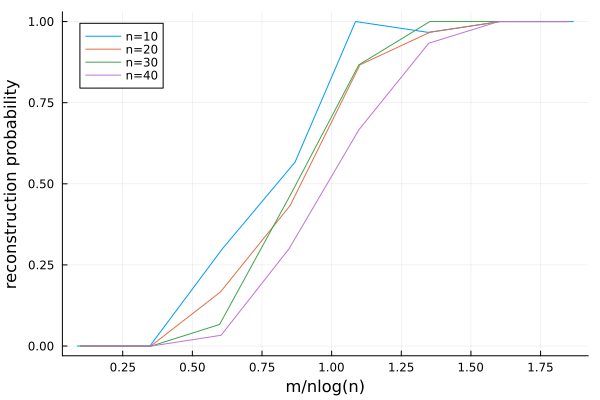

In [8]:
function algo(n,Omega,b)
    M_sol, _ = convex_relax(n,Omega,b)
    return M_sol
end
# Reduce the number of tests if you do not want to wait too long
empirical_rec_proba(1,10:10:45,algo;nb_tests=30)

It seems that, with probability close to $1$, the solution of the convex relaxation is the ground true matrix when $m \geq$constant$\times n\log(n)$.

Now, let us see how much time it takes to solve the convex relaxation, as a function of $n$.

n = 3
n = 6
n = 13
n = 25
n = 50
n = 100
n = 200
n = 398


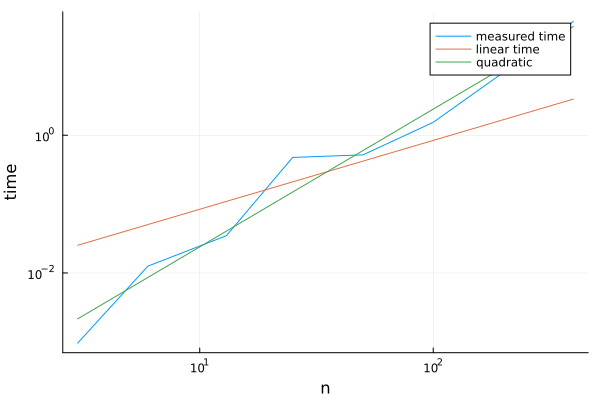

In [9]:
r = 1
# Reduce the number of tests if you do not want to wait too long
nb_tests = 30

ns = round.(Int64,10 .^(0.5:0.3:2.6))
times = zeros(length(ns))
for k=1:length(ns)
    n = ns[k]
    m = round(Int64,n*log(n)*1.8)
    println("n = ",ns[k])
    flush(stdout)

    for k_test = 1:nb_tests
        b, Omega, M = completion_problem(n,r,m)
        _, t = convex_relax(n,Omega,b)
        times[k] += t
    end
end
times = times / nb_tests
plot(ns,times,xlabel="n",ylabel="time",label="measured time",xaxis=:log,yaxis=:log)
plot!(ns,ns*geomean(times./ns),label="linear time")
plot!(ns,ns.^2*geomean(times./ns.^2),label="quadratic")

### Burer-Monteiro factorization

Let us fix a factorization rank $p \geq r_0$. The Burer-Monteiro factorization is
\begin{align}
\mbox{minimize } & \mathrm{Tr}(UU^T) \\
\mbox{over all } & U\in\mathbb{R}^{n\times p}\\
\mbox{such that } & (UU^T)_{i,j} = b_{i,j}, \forall (i,j) \in \Omega.
\end{align}

The set $\{U\in\mathbb{R}^{n\times p}, (UU^T)_{i,j} = b_{i,j}, \forall (i,j) \in \Omega\}$
is difficult
to manipulate. Instead of having it as a constraint, it is easier to incorporate it in the objective
through a penalization term:
\begin{align}
\mbox{minimize } & F(U) \overset{def}{=}\eta \mathrm{Tr}(UU^T) + \frac{1}{2}\sum_{(i,j)\in\Omega}||(UU^T)_{i,j} - b_{i,j}||^2 \\
\mbox{over all } & U\in\mathbb{R}^{n\times p}.
\end{align}
Here, $\eta>0$ is a small real number.

In [10]:
function cost(U,eta,Omega,b)
    c = eta*norm(U)^2
    for k=1:length(Omega)
        c += (sum(U[Omega[k][1],:].*U[Omega[k][2],:]) - b[k])^2/2
    end
    return c
end

cost (generic function with 1 method)

In [11]:
function gradient(U,eta,Omega,b)
    grad = 2*eta*U
    for k=1:length(Omega)
        coeff = sum(U[Omega[k][1],:].*U[Omega[k][2],:]) - b[k]
        grad[Omega[k][1],:] += coeff * U[Omega[k][2],:]
        grad[Omega[k][2],:] += coeff * U[Omega[k][1],:]
    end
    return grad
end

gradient (generic function with 1 method)

In [12]:
# Test if the gradient is correct
b, Omega, M = completion_problem(5,1,4)
eta = 0.1
U0 = randn(5,2)
Udot = randn(5,2)
println("Gradient along Udot : ", sum(Udot .* gradient(U0,eta,Omega,b)))
ep = 1e-4
println("Finite difference approximation : ", (cost(U0+ep*Udot,eta,Omega,b) -
        cost(U0,eta,Omega,b)) / ep)

Gradient along Udot : 2.1589138999456745
Finite difference approximation : 2.1588653607729213


In [13]:
function gradient_descent(Uinit,eta,Omega,b;nb_its = 100)

    # Initialize
    U = copy(Uinit)
    costs = zeros(nb_its+1)
    costs[1] = cost(U,eta,Omega,b)
    step = 0

    for k=1:nb_its
        
        # Compute gradient
        grad = gradient(U,eta,Omega,b)
        if (k==1)
            # Initial step value
            step = 0.1 * norm(U) / norm(grad)
        end
        # Compute next iterate
        U_test = U - step*grad
        
        # Backtrack, using Armijo-Goldstein stopping criterion
        while (cost(U_test,eta,Omega,b) > costs[k] - 0.1*step*norm(grad)^2)
            step = step / 2
            U_test = U - step*grad
        end
        step = 1.1 * step

        U .= U_test
        costs[k+1] = cost(U,eta,Omega,b)
        
    end

    return U,costs
end

gradient_descent (generic function with 1 method)

5×5 Matrix{Float64}:
  0.0262785   0.124666  -0.0752475   0.124686  -0.109199
  0.124666    0.591422  -0.356977    0.591515  -0.518047
 -0.0752475  -0.356977   0.215468   -0.357033   0.312688
  0.124686    0.591515  -0.357033    0.591608  -0.518128
 -0.109199   -0.518047   0.312688   -0.518128   0.453774

5×5 Matrix{Float64}:
  0.0187652   0.0992472  -0.059229   0.100133  -0.0832277
  0.0992472   0.524976   -0.313116   0.529603  -0.439799
 -0.059229   -0.313116    0.187224  -0.316023   0.26346
  0.100133    0.529603   -0.316023   0.534317  -0.444036
 -0.0832277  -0.439799    0.26346   -0.444036   0.37124

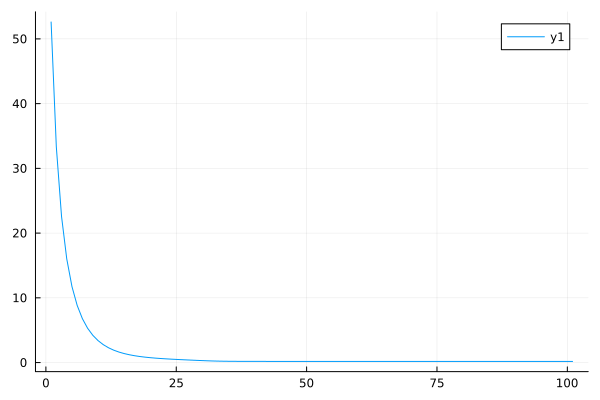

In [14]:
# Quick test
b, Omega, M = completion_problem(5,1,10)
eta = 0.1
Uinit = randn(5,2)
U,costs = gradient_descent(Uinit,eta,Omega,b)
display(M)
display(U*U')
plot(costs)

Let us investigate the importance of $\eta$.

Distance to true solution : 1.0
Distance to true solution : 0.24116869914803649
Distance to true solution : 0.02738006225685677
Distance to true solution : 0.0027897150548527316
Distance to true solution : 0.0002795235736913189


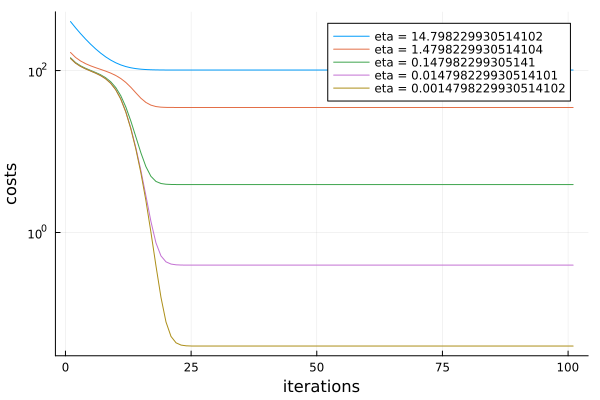

In [15]:
n = 20
r = 1
m = round(Int64,1.8*n*log(n))
b, Omega, M = completion_problem(n,r,m)

p = 1
Uinit = randn(n,p)

pl = plot(xlabel="iterations",ylabel="costs",yaxis=:log)

for eta in [1,1e-1,1e-2,1e-3,1e-4]*2*sqrt(m)*norm(b)/n
    U,costs = gradient_descent(Uinit,eta,Omega,b)
    println("Distance to true solution : ",norm(M - U*U') / norm(M))
    plot!(pl,costs,label=string("eta = ",eta))
end
plot(pl)

It seems that the precision on the solution is proportional to $\eta$.

**Partial justification in the case $r=p$**

We assume that, for small $\eta$, the minimizer of $F$ is of the form
$$U_{\min} = (1-\alpha_{\min}) U_{opt},$$
where $U_{opt}$ is such that $U_{opt}U_{opt}^T = M$. (This assumption can be justified, but it is more complicated.)

Then $\alpha_{\min}$ must be a minimizer of
$$\min_{\alpha\in\mathbb{R}} F((1-\alpha) U_{opt}).$$
The minimizer can be explicitely computed, and we obtain
$$1-\alpha_{\min}^2 = \eta \frac{\mathrm{Tr}(U_{opt}U_{opt}^T)}{||b||^2},$$
which leads to
$$1-\alpha_{\min} \approx \eta \frac{\mathrm{Tr}(U_{opt}U_{opt}^T)}{2||b||^2},$$
when $\eta$ is small. Therefore, the relative precision is indeed proportional to $\eta$.

This suggests that, if we want to compute the solution with relative error $\epsilon$, we should choose
$$\eta \approx \frac{2||b||^2\epsilon}{\mathrm{Tr}(U_{opt}U_{opt}^T)}.$$
The value of $\mathrm{Tr}(U_{opt}U_{opt}^T) = \mathrm{Tr}(M)$ is unknown but, if we assume that all coefficients of $M$ are roughly of the same order (in absolute value), we can estimate it as
$$\mathrm{Tr}(M) = \sum_{i=1}^n |M_{ii}| \approx \sqrt{\sum_{i,j=1}^n M_{ij}^2}
\approx \sqrt{\frac{n^2}{m} ||b||^2}=\frac{n||b||}{\sqrt{m}}.$$
Therefore, a good choice of $\eta$ should be
$$\eta \approx \frac{2\sqrt{m}||b||\epsilon}{ n}.$$

n = 10
  m =  2 8 14 20 25 31 37 43
n = 20
  m =  6 21 36 51 66 81 96 111
n = 30
  m =  10 36 61 87 112 138 163 189
n = 40
  m =  15 52 89 125 162 199 236 273


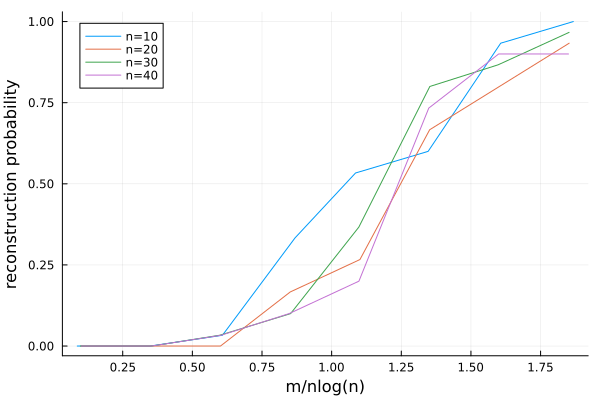

In [16]:
r = 1
p = 1
function algo(n,Omega,b)
    Uinit = randn(n,p)
    eta = 2 * sqrt(length(Omega)) * norm(b) * 1e-3 / n
    U,_ = gradient_descent(Uinit,eta,Omega,b)
    return U*U'
end
# Reduce the number of tests if you do not want to wait too long
empirical_rec_proba(r,10:10:45,algo;nb_tests=30)

Finally, we investigate the convergence rate of gradient descent. What happens when $\eta$ and $p$ vary?

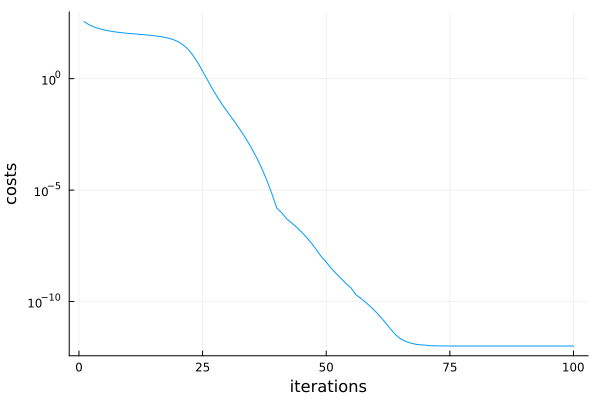

In [17]:
n = 50
r = 1
m = round(Int64,1.8*n*log(n))
b, Omega, M = completion_problem(n,r,m)

p = 1
Uinit = randn(n,p)
eta = 2 * sqrt(length(Omega)) * norm(b) * 1e-5 / n

U,costs = gradient_descent(Uinit,eta,Omega,b;nb_its=200)
plot(costs[1:100].-costs[end].+1e-12,xlabel="iterations",ylabel="costs",yaxis=:log,legend=false)